In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-wheat-detection-public/validation_results_fold1_best.csv
/kaggle/input/global-wheat-detection-public/validation_results_fold0_best.csv
/kaggle/input/global-wheat-detection-public/validation_results_fold3_best.csv
/kaggle/input/global-wheat-detection-public/benchmark_data.csv
/kaggle/input/global-wheat-detection-public/validation_results_fold4_best.csv
/kaggle/input/global-wheat-detection-public/validation_results_fold2_best.csv
/kaggle/input/global-wheat-detection-public/fasterrcnn_resnet50_fpn_best.pth


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from matplotlib.patches import Rectangle

In [4]:
df = pd.read_csv('/kaggle/input/global-wheat-detection-public/benchmark_data.csv')
df.head()

,image_id,PredictionString,map_score
0,b6ab77fd7,0.9970 778 302 93 87 0.9963 862 684 110 149 0....,0.744792
1,0435654cd,0.9940 691 411 154 90 0.9929 385 178 84 75 0.9...,0.676928
2,c6b4933f7,0.9961 785 665 86 100 0.9951 49 493 144 88 0.9...,0.855303
3,42e247347,0.9906 776 396 177 86 0.9890 0 598 160 100 0.9...,0.715897
4,5738fcf14,0.9957 502 786 151 96 0.9944 279 195 90 194 0....,0.778438


In [5]:
df.columns

Index(['image_id', 'PredictionString', 'map_score'], dtype='object')

In [6]:
df = pd.read_csv('/kaggle/input/global-wheat-detection-public/validation_results_fold0_best.csv')
df.head()

,image_id,PredictionString,bounding_boxes,map_score
0,f5093f57d,0.9988 162 282 157 105 0.9977 381 244 117 109 ...,NaN,0.755028
1,4aeb37788,0.9968 365 109 103 95 0.9967 2 314 121 84 0.99...,NaN,0.660783
2,c3c03e0b7,0.9887 130 683 201 59 0.9847 90 129 257 101 0....,NaN,0.340920
3,42e247347,0.9946 0 469 131 77 0.9946 588 142 176 107 0.9...,NaN,0.491839
4,ca4cb597b,0.9948 461 348 117 99 0.9936 651 250 85 61 0.9...,NaN,0.505429


In [7]:
df.columns

Index(['image_id', 'PredictionString', 'bounding_boxes', 'map_score'], dtype='object')

In [8]:
# Load the benchmark and validation results
benchmark_df = pd.read_csv('/kaggle/input/global-wheat-detection-public/benchmark_data.csv')
validation_df = pd.read_csv('/kaggle/input/global-wheat-detection-public/validation_results_fold0_best.csv')

In [9]:
print("📘 Benchmark Columns:\n", benchmark_df.columns)
print("🧪 Validation Columns:\n", validation_df.columns)

📘 Benchmark Columns:
 Index(['image_id', 'PredictionString', 'map_score'], dtype='object')
🧪 Validation Columns:
 Index(['image_id', 'PredictionString', 'bounding_boxes', 'map_score'], dtype='object')


In [10]:
# Show first few rows
benchmark_df.head()

,image_id,PredictionString,map_score
0,b6ab77fd7,0.9970 778 302 93 87 0.9963 862 684 110 149 0....,0.744792
1,0435654cd,0.9940 691 411 154 90 0.9929 385 178 84 75 0.9...,0.676928
2,c6b4933f7,0.9961 785 665 86 100 0.9951 49 493 144 88 0.9...,0.855303
3,42e247347,0.9906 776 396 177 86 0.9890 0 598 160 100 0.9...,0.715897
4,5738fcf14,0.9957 502 786 151 96 0.9944 279 195 90 194 0....,0.778438


In [11]:
validation_df.head()

,image_id,PredictionString,bounding_boxes,map_score
0,f5093f57d,0.9988 162 282 157 105 0.9977 381 244 117 109 ...,NaN,0.755028
1,4aeb37788,0.9968 365 109 103 95 0.9967 2 314 121 84 0.99...,NaN,0.660783
2,c3c03e0b7,0.9887 130 683 201 59 0.9847 90 129 257 101 0....,NaN,0.340920
3,42e247347,0.9946 0 469 131 77 0.9946 588 142 176 107 0.9...,NaN,0.491839
4,ca4cb597b,0.9948 461 348 117 99 0.9936 651 250 85 61 0.9...,NaN,0.505429


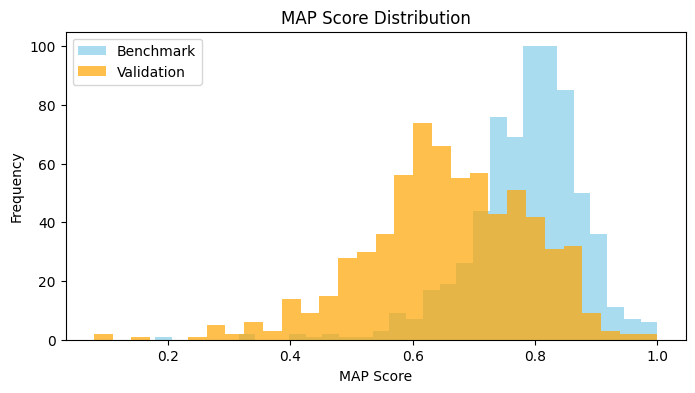

In [12]:
plt.figure(figsize=(8,4))
plt.hist(benchmark_df['map_score'], bins=30, alpha=0.7, label='Benchmark', color='skyblue')
plt.hist(validation_df['map_score'], bins=30, alpha=0.7, label='Validation', color='orange')
plt.title('MAP Score Distribution')
plt.xlabel('MAP Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [13]:
def parse_predictions(pred_str):
    if pd.isna(pred_str):
        return []
    nums = list(map(float, pred_str.strip().split()))
    return [nums[i:i+5] for i in range(0, len(nums), 5)]

In [14]:
image_folder = '/kaggle/input/global-wheat-detection/train'

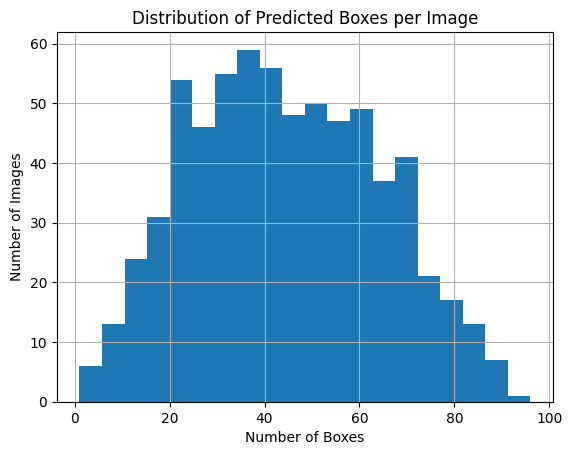

In [15]:
# Count how many boxes per image
def count_boxes(pred_str):
    if pd.isna(pred_str):
        return 0
    return len(pred_str.strip().split()) // 5

df['box_count'] = df['PredictionString'].apply(count_boxes)

# Plot box count distribution
df['box_count'].hist(bins=20)
plt.title("Distribution of Predicted Boxes per Image")
plt.xlabel("Number of Boxes")
plt.ylabel("Number of Images")
plt.show()

In [16]:
print("🔢 Total benchmark images:", benchmark_df.shape[0])
print("📦 Total validation images:", validation_df.shape[0])
print("📈 Mean MAP Score - Benchmark:", benchmark_df['map_score'].mean())
print("📈 Mean MAP Score - Validation:", validation_df['map_score'].mean())

🔢 Total benchmark images: 675
📦 Total validation images: 675
📈 Mean MAP Score - Benchmark: 0.7849271396550881
📈 Mean MAP Score - Validation: 0.65671290268749
